#Thư viện

In [1]:
#Import Necessary Libraries 
import scipy.io
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg 
import seaborn as sns
from skimage.io import imread, imshow
%matplotlib inline
from PIL import Image, ImageFile, ImageFilter
from skimage.feature import hog 
import skimage
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import fnmatch
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, auc
import os
import sys
import cv2
from google.colab.patches import cv2_imshow
from sklearn.naive_bayes import GaussianNB

# Nguồn dữ liệu

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path_img = "/content/drive/MyDrive/UIT 2022 - 2023/Máy học /Skin Cancer Detection/[V2] Dataset"

path_OR_malignant = os.path.join(path_img, "Original Data/Malignant")
path_OR_benign = os.path.join(path_img, "Original Data/Benign")

# Sử dụng dữ liệu Self-collected để thử nghiệm
path_SC_malignant = os.path.join(path_img, "Self-collected Data/Malignant/")
path_SC_benign = os.path.join(path_img, "Self-collected Data/Benign/")

# Lưu kết quả 

In [4]:
def Result(y_test, y_pred):
    a = metrics.accuracy_score(y_test, y_pred)
    p = metrics.precision_score(y_test, y_pred)
    r = metrics.recall_score(y_test, y_pred)
    f = metrics.f1_score(y_test, y_pred)

    print("Accuracy:", a)
    print("Precision:", p)
    print("Recall:", r)
    print("F1-score:", f)

    return a, p, r, f

In [5]:
def ConfusionMatrix(y_test, y_pred):
    cf_matrix = confusion_matrix(y_test, y_pred)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in
                        cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

# Xử lý dữ liệu Original

Mỗi hình ảnh sẽ có kích thước khác nhau. Do đó, cần đưa tất cả hình ảnh về 1 kịch thước để xử lý. Theo như kết quả dưới đây, kích thước (h, w) lớn nhất là (4459, 6688) và nhỏ nhất là (450, 600). 

In [6]:
x = []
y = []
path = [path_OR_malignant, path_OR_benign]
for pat in path:
    for item in os.listdir(pat):
        img = Image.open(os.path.join(pat, item))
        width, height = img.size
        x.append(height)
        y.append(width)
                                                                                                     

print("Min Height, Width:", min(x), min(y))
print("Max Height, Width:", max(x), max(y))

Min Height, Width: 450 600
Max Height, Width: 4459 6688


Chúng tôi lựa chọn kích thước (450, 600) cho toàn bộ ảnh, ảnh sẽ được chuyển về ảnh xám để dễ xử lý. 

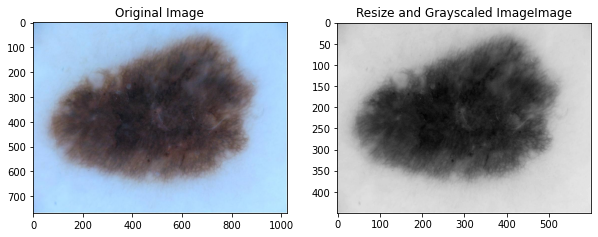

In [7]:
# Minh họa Cho việc xử lý ảnh
path = os.path.join(path_OR_benign, "ISIC_0000000.jpg")
img = Image.open(path)
imgResize = img.resize((600,450), Image.ANTIALIAS).convert('L')

plt.figure(figsize = (10, 10))
plt.subplot (121)
plt.imshow (img)
plt.title ('Original Image')

plt.subplot (122)
plt.imshow (imgResize, cmap = plt.get_cmap('gray'))
plt.title ('Resize and Grayscaled ImageImage')
plt.show()

In [8]:
#Thư viện PIL hỗ trợ trong việc xử lý ảnh. 
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [9]:
# Đọc và xử lý dữ liệu
def ProcessingData (path, label = 1):
  data = []
  for item in os.listdir(path):
    
      # Đọc ảnh, resize và chuyển đổi ảnh xám
      img = Image.open(os.path.join(path, item))
      img = img.resize((600,450), Image.ANTIALIAS).convert('L')

      # Làm phẳng hình ảnh
      data_array = np.array(img).flatten()
      data.append(data_array)
    
  dataset = np.asarray(data)
  data_df = pd.DataFrame(data = dataset[0:, 0:],
                         index = [i for i in range(dataset.shape[0])],
                         columns = [str(i) for i in range(dataset.shape[1])] )
  # Gán nhãn
  data_df[len(data_df.columns)] = label
  return data_df


In [10]:
malig_df = ProcessingData(path_OR_malignant, 0)
benign_df = ProcessingData(path_OR_benign, 1)

In [11]:
print(malig_df)
print(benign_df)

       0    1    2    3    4    5    6    7    8    9  ...  269991  269992  \
0     28   29   31   33   36   40   43   44   46   49  ...      15      14   
1    105  107  112  112  114  118  120  120  122  123  ...     111     109   
2    111  112  111  111  115  115  117  118  120  122  ...     104     101   
3    234  220  224  223  224  225  225  222  222  224  ...     229     228   
4    132  132  133  135  135  138  140  140  143  147  ...     128     128   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...     ...     ...   
720  155  160  159  163  164  164  168  169  170  167  ...     104     103   
721   22   19   20   21   22   24   17   16   20   18  ...      66      62   
722   85   89   89   89   92   89   94  100  104  105  ...      73      69   
723   14   22   40   46   44   45   40   31   25   24  ...      11      11   
724  115  116  118  119  120  123  122  126  123  124  ...     131     131   

     269993  269994  269995  269996  269997  269998  269999  27

In [12]:
# Kết nối 2 bộ dữ liệu malignant và benign với nhau
cancer_df = pd.concat([malig_df, benign_df], ignore_index=True, sort =False)

Dữ liệu đầu vào sẽ được chuẩn hóa bằng ***StandarScaler(***). Hàm này được sử dụng để quy đổi tỷ lệ của các giá trị khác nhau để so sánh. 

Công thức chuẩn của phương pháp standardization như sau:
**z = (x – u ) / s**

**Trong đó:**

*   z : là giá trị mới.
*   x : là giá trị gốc ban đầu.
*   u : là giá trị trung bình (mean).
*   s : là độ lệch chuẩn.



In [13]:
# Tách nhãn ra khỏi dữ liệu, df chỉ chứa nhãn của hình
cancer_df_sliced = cancer_df.iloc[:,:-1]
df = cancer_df.iloc[:,-1]

# Chuẩn hóa dữ liệu bằng cách loại bỏ các giá trị trung bình và chia tỷ lệ theo phương sai của đơn vị
cancer_norm = StandardScaler().fit_transform(cancer_df_sliced)
cancer_norm = pd.DataFrame(cancer_norm)
 
# Gắn nhãn vào dữ liệu đã được chuẩn hóa
cancer_norm['270000'] = df.values

# Chia dataframe thành feature và label
cancer_feature = cancer_norm.iloc[:,:-1]
cancer_label = cancer_norm.iloc[:,-1]

PCA được dùng để làm giảm số lượng feature trong bộ dữ liệu. Trong tổng số 27000 features, có 18 features chiếm 90% phương sai. Do đó, có thể giảm thiểu được chi phí tính toán khi chỉ xử lý trên 18 features

In [14]:
# Chia bộ dữ liệu train và test
x_train, x_test, y_train, y_test = train_test_split(cancer_feature, cancer_label, test_size=0.30, random_state=30)

# Sử dụng PCA để trích xuất features đặc trưng chiếm 90% phương sai
pca = PCA(0.9)
pca.fit(x_train)

print('Number of Features that account for 90% variance: ', pca.n_components_)

# Dữ lại features đặc trưng và loại bỏ các feature còn lại  
train_img_pca = pca.transform(x_train)
test_img_pca = pca.transform(x_test)

Number of Features that account for 90% variance:  18


In [15]:
print (train_img_pca)
print (test_img_pca)

[[ 1.58710790e+02 -7.11340449e+01  2.37482126e+01 ... -1.50936633e+00
  -6.67285901e+00  6.10181279e-01]
 [ 2.00140374e+02  3.25228144e+01 -1.94721895e+01 ... -1.50704935e+01
  -9.32218707e+00 -2.20353815e+00]
 [ 1.25016351e+02 -2.86551826e+02 -6.80110704e+01 ... -1.05501030e+01
   2.66556119e+01  6.34724696e+00]
 ...
 [-5.40982058e+02  4.60171455e+02  6.27825532e+01 ... -1.74329472e+01
   6.19869446e+01 -4.13217087e+00]
 [-6.39010630e+02 -3.87360872e+01  2.30941780e+01 ... -1.68159787e+01
  -3.58474257e+00 -3.65137983e+00]
 [-1.43475389e+02 -2.45996229e+02 -1.08284578e+02 ... -1.73791794e+01
  -8.66852117e+00  8.02532159e-01]]
[[-307.14117067 -121.28520616   17.89877139 ...   -3.34143956
     4.05836121    4.01021533]
 [ 192.15742092  120.72591469  -30.58554258 ...  -16.24983196
    16.25997331    3.6281822 ]
 [-479.4792834   -72.07087268   40.31826005 ...  -22.83534637
     6.66940374  -12.44077363]
 ...
 [-414.36751003  -75.18676167   22.89196735 ...  -23.20347805
    -2.74623586   

# Mô hình xử lý trên pixel

## Logistic Regression


In [ ]:
logreg = LogisticRegression()
logreg.fit(train_img_pca, y_train)
y_pred = logreg.predict(test_img_pca)

# Tính toán đường cong ROC để tính toán tỷ lệ dương tính thật sự với dương tính giả. Sau đó sử dụng AUC (Area Under the Curve) để kiểm tra hiệu suất của mô hình.
y_pred_proba = logreg.predict_proba(test_img_pca)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
roc_auc = auc(fpr, tpr)
print(roc_auc)

# Vẽ AUC
plt.title('ROC (Receiver Operating Characteristic)')
plt.plot(fpr, tpr, 'b', label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate (TPR)')
plt.xlabel('False Positive Rate (FPR)')
plt.show()

#Kết quả
lr_a, lr_p, lr_r, lr_f = Result (y_test, y_pred) 

In [ ]:
ConfusionMatrix(y_test, y_pred)

In [ ]:
# Validation score 
lr_v = cross_val_score(logreg, train_img_pca , y_train, cv = 10, scoring = 'accuracy').mean()
print('Logistic Regression Validation Score: ', lr_v)

## SVM


In [ ]:
#Apply SVM, fit on train set and predict test set 
clf = svm.SVC(kernel='linear') 
clf.fit(train_img_pca,y_train)
y_pred = clf.predict(test_img_pca)

#Display classification result 
svm_a, svm_p, svm_r, svm_f = Result (y_test, y_pred) 

In [ ]:
ConfusionMatrix(y_test, y_pred)

In [ ]:
#Display validation result
svm_v = cross_val_score(clf, train_img_pca , y_train, cv = 2, scoring = 'accuracy').mean()
print('SVM validation score: ', svm_v)

## KNN

In [ ]:
#Apply knn, fit on train set and predict test set.
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(train_img_pca,y_train)
y_pred = knn.predict(test_img_pca)

knn_a, knn_p, knn_r, knn_f = Result (y_test, y_pred) 

In [ ]:
ConfusionMatrix(y_test, y_pred)

In [ ]:
#Determine and display validation result 
knn_v = cross_val_score(knn, train_img_pca , y_train, cv = 10, scoring = 'accuracy').mean()
print('K-NN validation score', knn_v)

## Tổng kết

In [ ]:
import pandas as pd 

In [ ]:
a = [lr_a, knn_a, svm_a]
p = [lr_p, knn_p, svm_p]
r = [lr_r, knn_r, svm_r]
f = [lr_f, knn_f, svm_f]
v = [lr_v, knn_v, svm_v]

col={'Accuracy':a, 'Precission':p, 'Recall':r, 'F1 Score':f, 'Validation':v}
models=['Logistic Regression', 'KNN', 'SVM']
df = pd.DataFrame(data = col,index = models)
df

# Xử lý dữ liệu FE

Dữ liệu được xử lý thông qua các bước sau:


*   Resize (100x100)
*   Blue Channel
*   Dilation
*   Contrast Limited Adaptive Histogram Equalization (CLAHE) 



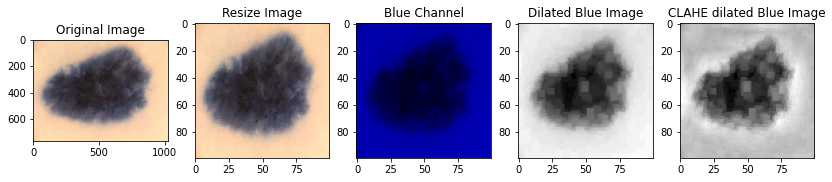

In [16]:
# Minh họa cho quá trình xử lý 

path = os.path.join(path_OR_benign, "ISIC_0000000.jpg")
img = cv2.imread(path)

# Resize (100,100)
imgResize = cv2.resize(img, (100,100), Image.ANTIALIAS)      

# Blue channel 
# set green and red channels to 0
imgBlue = imgResize.copy()
imgBlue[:, :, 0] = 0
imgBlue[:, :, 1] = 0

# Dilation 
grayimg = cv2.cvtColor(imgBlue, cv2.COLOR_BGR2GRAY)
kernel = np.ones((5, 5), np.uint8)
imgDilation = cv2.dilate(grayimg, kernel, iterations=1)

# CLAHE
clahe = cv2.createCLAHE(clipLimit = 2.0, tileGridSize = (8,8))
imgCLAHE = clahe.apply(imgDilation)

# Show ảnh
plt.figure(figsize = (14, 14))
plt.subplot (151)
plt.imshow (img)
plt.title ('Original Image')

plt.subplot (152)
plt.imshow (imgResize)
plt.title ('Resize Image')

plt.subplot (153)
plt.imshow (imgBlue)
plt.title ('Blue Channel')

plt.subplot (154)
plt.imshow (imgDilation, cmap = plt.get_cmap('gray'))
plt.title ('Dilated Blue Image')

plt.subplot (155)
plt.imshow (imgCLAHE, cmap = plt.get_cmap('gray'))
plt.title ('CLAHE dilated Blue Image')
plt.show()

In [17]:
dataFE_array = hog(imgCLAHE, cells_per_block = (2, 2))
dataFE_array.shape

(4356,)

In [18]:
def ProcessingDataFE(path, label):
    dataFE = []
    for item in os.listdir(path):

        img = cv2.imread(os.path.join(path, item))

        # Resize (100,100)
        imgResize = cv2.resize(img, (100,100), Image.ANTIALIAS)      

        # Blue channel 
        # set green and red channels to 0
        imgBlue = imgResize.copy()
        imgBlue[:, :, 0] = 0
        imgBlue[:, :, 1] = 0

        # Dilation 
        grayimg = cv2.cvtColor(imgBlue, cv2.COLOR_BGR2GRAY)
        kernel = np.ones((5, 5), np.uint8)
        imgDilation = cv2.dilate(grayimg, kernel, iterations=1)

        # CLAHE
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        imgCLAHE = clahe.apply(imgDilation)

        # Trích xuất HOS cho hình ảnh
        dataFE_array = hog(imgCLAHE, cells_per_block = (2, 2))
        dataFE.append(dataFE_array)

    #Convert list to array
    dataFE_2d = np.asarray(dataFE)
    #Convert array to dataframe
    dataFE_df = pd.DataFrame(data=dataFE_2d[0:,0:],
                            index=[i for i in range(dataFE_2d.shape[0])],
                            columns=[str(i) for i in range(dataFE_2d.shape[1])])
    
    # Gán nhãn
    dataFE_df[len(dataFE_df.columns)] = label
    return (dataFE_df)


In [19]:
malig_fe_df = ProcessingDataFE(path_OR_malignant, 0)
ben_fe_df = ProcessingDataFE(path_OR_benign, 1)

In [20]:
# Kết nối 2 file
cancer_fe_df = pd.concat([malig_fe_df, ben_fe_df], ignore_index = True, sort =False)

#Split dataframe into feature and label
cancer_fe_feature = cancer_fe_df.iloc[:,:-1]
cancer_fe_label = cancer_fe_df.iloc[:,-1]
#Split into train and test set
x_fe_train, x_fe_test, y_fe_train, y_fe_test = train_test_split(cancer_fe_feature, cancer_fe_label, test_size=0.3, random_state=141)


# Mô hình FE

## SVM

In [21]:
#Fit SVM to train set and use it to predict the test set 
svm_clf = svm.SVC(kernel='linear') 
svm_clf.fit(x_fe_train, y_fe_train)
prediction = svm_clf.predict(x_fe_test)
#Display classification result 
svm_a, svm_p, svm_r, svm_f = Result (y_fe_test, prediction) 

Accuracy: 0.6551724137931034
Precision: 0.6508620689655172
Recall: 0.6863636363636364
F1-score: 0.6681415929203539


In [22]:
svm_v = cross_val_score(svm_clf, x_fe_train , y_fe_train, cv = 10, scoring = 'accuracy').mean()
print('SVM on Feature Engineered Images: ', svm_v)

SVM on Feature Engineered Images:  0.6365851291011454


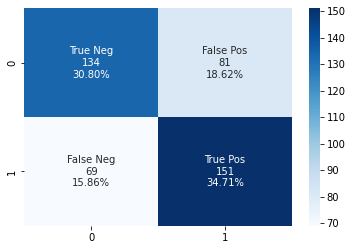

In [23]:
ConfusionMatrix (y_fe_test, prediction)

## Gaussian naive bayes

In [24]:
#Apply gaussian naive bayes to fit train set and predic test set 
model = GaussianNB()

model.fit(x_fe_train,y_fe_train)
prediction = model.predict(x_fe_test)

#Display classification result
gnb_a, gnb_p, gnb_r, gnb_f = Result (y_fe_test, prediction) 

Accuracy: 0.6689655172413793
Precision: 0.7065217391304348
Recall: 0.5909090909090909
F1-score: 0.6435643564356436


In [25]:
#Determine validation score and displaying it 
gnb_v = cross_val_score(model, x_fe_train , y_fe_train, cv = 10, scoring = 'accuracy').mean()
print('Gaussian Naive Bayes Validation score', gnb_v)

Gaussian Naive Bayes Validation score 0.7034459328285769


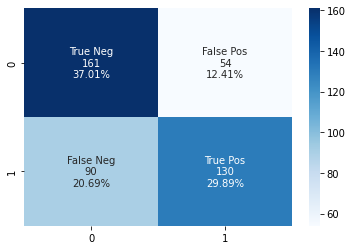

In [26]:
ConfusionMatrix (y_fe_test, prediction)

## Tổng kết


In [27]:
a = [gnb_a, svm_a]
p = [gnb_p, svm_p]
r = [gnb_r, svm_r]
f = [gnb_f, svm_f]
v = [gnb_v, svm_v]

col={'Accuracy':a, 'Precission':p, 'Recall':r, 'F1 Score':f, 'Validation':v}
models=['Gaussian naive bayes', 'SVM']
df = pd.DataFrame(data = col,index = models)
df

,Accuracy,Precission,Recall,F1 Score,Validation
Gaussian naive bayes,0.668966,0.706522,0.590909,0.643564,0.703446
SVM,0.655172,0.650862,0.686364,0.668142,0.636585


# Dự đoán với dữ liệu thực tế




In [84]:
# Đọc ảnh
img_path = os.path.join (path_SC_malignant, "1.jpg")
img = cv2.imread (img_path)

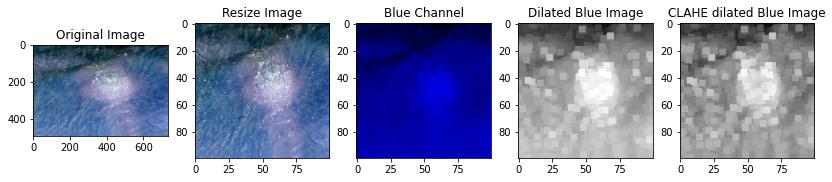

In [83]:
# Resize
imgResize = cv2.resize(img, (100,100), Image.ANTIALIAS) 

# Blue channel 
# set green and red channels to 0
imgBlue = imgResize.copy()
imgBlue[:, :, 0] = 0
imgBlue[:, :, 1] = 0

# Dilation 
grayimg = cv2.cvtColor(imgBlue, cv2.COLOR_BGR2GRAY)
kernel = np.ones((5, 5), np.uint8)
imgDilation = cv2.dilate(grayimg, kernel, iterations=1)

# CLAHE
clahe = cv2.createCLAHE(clipLimit = 2.0, tileGridSize = (8,8))
imgCLAHE = clahe.apply(imgDilation)

# Show ảnh
plt.figure(figsize = (14, 14))
plt.subplot (151)
plt.imshow (img)
plt.title ('Original Image')

plt.subplot (152)
plt.imshow (imgResize)
plt.title ('Resize Image')

plt.subplot (153)
plt.imshow (imgBlue)
plt.title ('Blue Channel')

plt.subplot (154)
plt.imshow (imgDilation, cmap = plt.get_cmap('gray'))
plt.title ('Dilated Blue Image')

plt.subplot (155)
plt.imshow (imgCLAHE, cmap = plt.get_cmap('gray'))
plt.title ('CLAHE dilated Blue Image')
plt.show()

In [85]:
# Trích xuất HOS cho hình ảnh
dataFE_array = hog(imgCLAHE, cells_per_block = (2, 2))
print(dataFE_array)
print(type(dataFE_array))

[0.20122246 0.         0.01080651 ... 0.2649273  0.1225276  0.0177359 ]
<class 'numpy.ndarray'>


In [86]:
dataFE_df = pd.DataFrame(dataFE_array)
dataFE_df

,0
0,0.201222
1,0.000000
2,0.010807
3,0.000000
4,0.147733
...,...
4351,0.264927
4352,0.177021
4353,0.264927
4354,0.122528


In [87]:
dataFE_df = dataFE_df.transpose()
dataFE_df

,0,1,2,3,4,5,6,7,8,9,...,4346,4347,4348,4349,4350,4351,4352,4353,4354,4355
0,0.201222,0.0,0.010807,0.0,0.147733,0.075323,0.043226,0.017087,0.036469,0.293859,...,0.121933,0.264927,0.009619,0.110525,0.057712,0.264927,0.177021,0.264927,0.122528,0.017736


In [89]:
prediction = svm_clf.predict(dataFE_df)
if prediction == 0: print ("Predicted Result: Malignant")
else: print ("Predicted Result: Benign")

Predicted Result: Malignant


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
